In [1]:
from settings import *

In [2]:
import sys
sys.path.append(ROOT)

In [3]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os

from aux.aux import *
from dfply import *

sns.set()

%matplotlib inline

In [4]:
sklearn.__version__

'0.19.1'

In [5]:
pd.__version__

'0.19.2'

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
d = pd.read_csv(os.path.join(ROOT, 'data', 'data.csv'))
d = d[[col for col in d.columns if col != 'isFlaggedFraud']]

# EXPLORATORY DATA ANALYSIS

In [8]:
d.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


#### Check for NULL values

In [9]:
d.isnull().values.any()

False

#### Univariate exploration of distributions

In [10]:
# fraud label breakdown
# d.isFraud.value_counts()
d.groupby('isFraud')[['isFraud']].count() # nicer output if kept as a dataframe

# Conclusion - the fraud variable is extremely skewed, only 0.13% of events

,isFraud
isFraud,
0,6354407
1,8213


In [11]:
# explore nameOrig - customer who started the transaction (all customer)
d.nameOrig.str[0].value_counts()

# Conclusion - all are C type

C    6362620
Name: nameOrig, dtype: int64

In [12]:
# Percentage of unique nameOrig
round(len(d.nameOrig.unique()) / d.shape[0], 3)

# Conclusion - almost a unique column, not to be used.

0.999

In [13]:
# Percentage of unique nameDest
round(len(d.nameDest.unique()) / d.shape[0], 3)

# Conclusion - too many unique values, not to be used in raw form.

0.428

#### Explore nameDest counts (the recipient of the transaction M/C)

C    4211125
M    2151495
Name: nameDest, dtype: int64


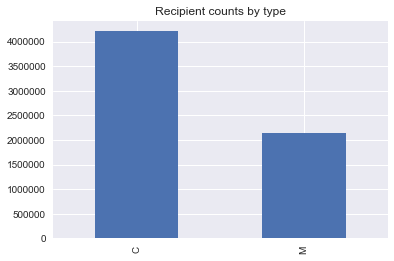

In [14]:
print(d.nameDest.str[0].value_counts())
d.nameDest.str[0].value_counts().plot(kind='bar', title = 'Recipient counts by type');

# Conclusion - fairly distributed among classes

#### Payment type breakdown

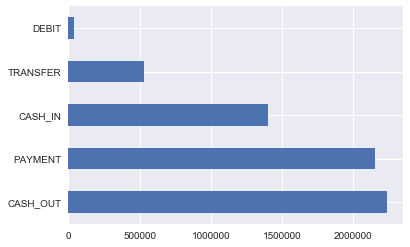

In [15]:
d.type.value_counts().plot(kind='barh');

# Conclusion - the fraud variable is extremely skewed, only 0.13% of events

In [16]:
# Assuming that step 1 means the first hour of the first day of simulation, and step 744 last hour of simulation, 
# and that each step corresponds to the order of the hour, we can calculate which hour of day and day of week the 
# observation took place on. We cannot know which exact day or hour it is, but can group all obervations into the 
# same hour or day groups.
day = (d.step // 24) %7
hour = d.step % 24

#### Plot hour distribution

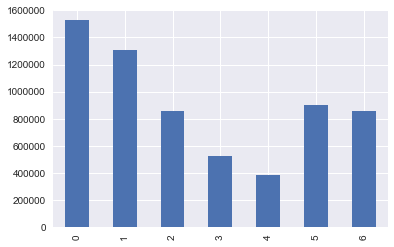

In [17]:
day.value_counts().sort_index().plot(kind='bar');

#### Plot hour distribution

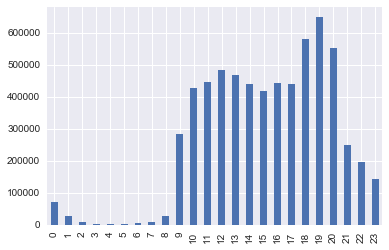

In [18]:
hour.value_counts().sort_index().plot(kind='bar');

#### Balance variables histograms

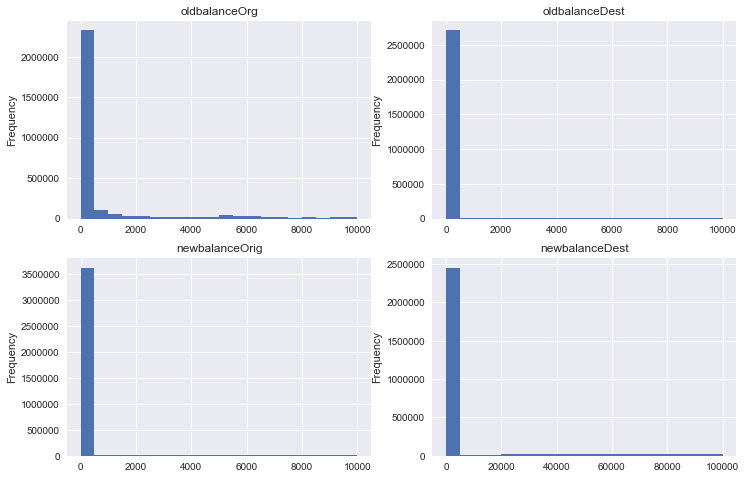

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# .plot(kind='hist', bins=100, ax=axes[0], logy=True, normed=1, title='Sampled population', alpha=0.5);

d.oldbalanceOrg[d.oldbalanceOrg<10000].plot(kind='hist', ax=axes[0,0], title='oldbalanceOrg', bins=20)
d.oldbalanceDest[d.oldbalanceDest<10000].plot(kind='hist', ax=axes[0,1], title='oldbalanceDest', bins=20);

d.newbalanceOrig[d.newbalanceOrig<10000].plot(kind='hist', ax=axes[1,0], title='newbalanceOrig', bins=20)
d.newbalanceDest[d.newbalanceDest<100000].plot(kind='hist', ax=axes[1,1], title='newbalanceDest', bins=20);


# Conclusion - balance variables are extremely skewed with a large majority of values being 0

### Bivariate exploration

#### Which DESTINATIONS have the highest number of fraudulent transactions

In [20]:
pd.crosstab(index=d.nameDest, columns=d.isFraud).reset_index().sort_values(by=[1], ascending=False).head(10)

# Conclusion: maximal number of frauds per destination is 2 with many occurrences - no substantial outliers 
# (also too few occurrences of frauds per destination to achieve statistical significance).

isFraud,nameDest,0,1
108539,C1366192319,10,2
136628,C1460854172,10,2
57504,C1193568854,35,2
468311,C650699445,7,2
425624,C505532836,4,2
334402,C2129197098,8,2
296180,C200064275,31,2
230857,C1780714769,4,2
55009,C1185292292,4,2
76709,C1259079602,7,2


#### Which ORIGINS have the highest number of fraudulent transactions

In [21]:
pd.crosstab(index=d.nameOrig, columns=d.isFraud).reset_index().sort_values(by=1, ascending=False).head(10)

# Conclusion: maximal number of frauds per destination is 1 with many occurrences - no substantial outliers 
# (even percentage - wise is not significant)

isFraud,nameOrig,0,1
3281729,C1998644906,0,1
4486663,C43271707,0,1
3457566,C2052061131,0,1
1714043,C1521962059,0,1
5873174,C853796614,0,1
5281344,C673988903,0,1
3795375,C222155538,0,1
3851541,C239145615,0,1
2659313,C1809515003,0,1
423232,C1129139063,0,1


#### Crosstab destination type (M / C) and fraud label 

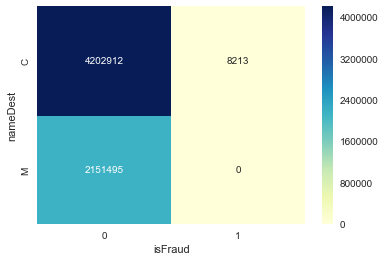

In [22]:
pd.crosstab(index=d.nameDest.str[0], columns=d.isFraud).loc[:,[0,1]] >> heatmap(annot = True)

# Conclusion: all frauds are done when destination is C

#### Crosstab payment type and fraud label
* Left plot: crosstab counts
* Right plot: fraud odds per payment type

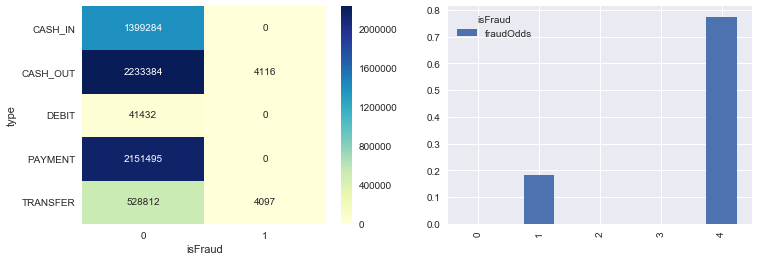

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Crosstab payment type and fraud label
pd.crosstab(index=d.type, columns=d.isFraud).loc[:,[0,1]] >> heatmap(annot = True, ax=axes[0])


# plot the fraud odds count per hour of day
fraudOdds = pd.crosstab(index=d.type, columns=d.isFraud).iloc[:7].reset_index() >> \
    select([1, 2]) >> \
    rename(frauds = 1, nonfrauds = 0) >> \
    mutate(fraudOdds = X.frauds / X.nonfrauds * 100) >> \
    select(X.fraudOdds)
    
fraudOdds.plot(kind='bar', ax=axes[1]);


# Conclusion: all frauds are done on CASH_OUT and TRANSFER payments. We can join other categories into one as 
# they have identical behaviour with regards to fraud events

#### Crosstab weekday and fraud label
* Left plot: crosstab counts
* Right plot: fraud odds per weekday

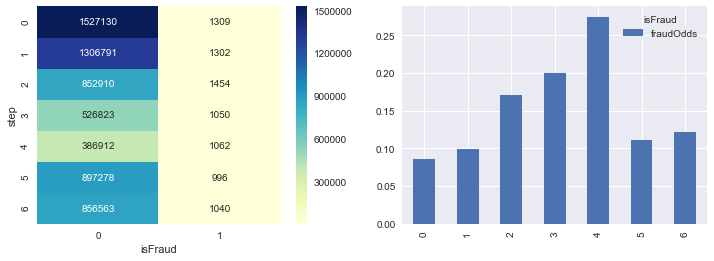

In [24]:
# Inspect fraud odds per day of week (quotient #frauds/#nonfrauds)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# plot the crosstab fraud indicator vs hour of day
pd.crosstab(index=day, columns=d.isFraud).loc[:,[0,1]] >> heatmap(annot = True, ax=axes[0]);


# plot the fraud odds count per hour of day
fraudOdds = pd.crosstab(index=day, columns=d.isFraud).iloc[:7].reset_index() >> \
    select([1, 2]) >> \
    rename(frauds = 1, nonfrauds = 0) >> \
    mutate(fraudOdds = X.frauds / X.nonfrauds * 100) >> \
    select(X.fraudOdds)
    
fraudOdds.plot(kind='bar', ax=axes[1]);

# Inspect fraud odds per hour of day (quotient #frauds/#nonfrauds)
# Conclusion - on some days the chance of frauds is significantly higher

#### Crosstab hour of day and fraud label
* Left plot: crosstab counts
* Right plot: fraud odds per hour of day

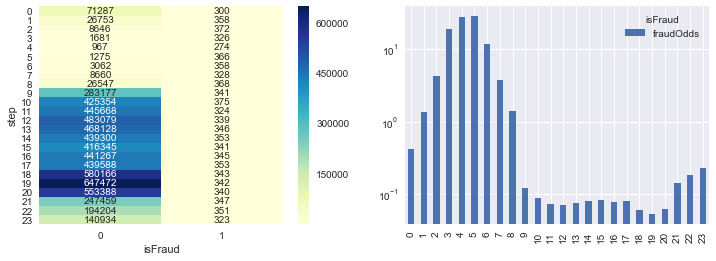

In [25]:
# Inspect fraud odds per hour of day (quotient #frauds/#nonfrauds)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# plot the crosstab fraud indicator vs hour of day
pd.crosstab(index=hour, columns=d.isFraud).loc[:,[0,1]] >> heatmap(annot = True, ax=axes[0]);


# plot the fraud odds count per hour of day
fraudOdds = pd.crosstab(index=hour, columns=d.isFraud).iloc[:24].reset_index() >> \
    select([1, 2]) >> \
    rename(frauds = 1, nonfrauds = 0) >> \
    mutate(fraudOdds = X.frauds / X.nonfrauds * 100) >> \
    select(X.fraudOdds)
    
fraudOdds.plot(kind='bar', logy=True, ax=axes[1]);

# Conclusion - on some hours of day the chance of frauds is significantly higher

#### Inspect the distribution of amount per fraud / nonfraud

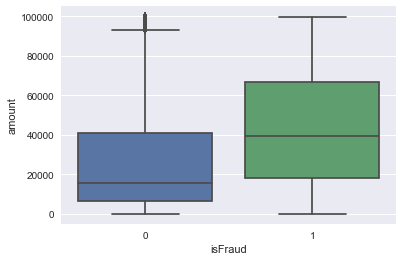

In [26]:
sns.boxplot(x = 'isFraud', y = 'amount', data = d[d.amount < 100000]);

# Conclusion - we can see that the amount transfered is higher on average on fraudulent transactions

#### Inspect the distribution of oldbalanceOrg per fraud/nonfraud

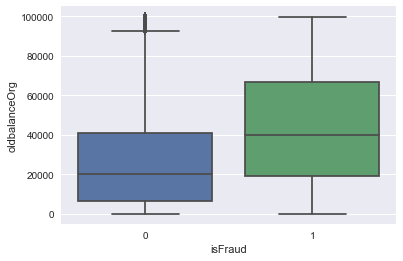

In [27]:
sns.boxplot(x = 'isFraud', y = 'oldbalanceOrg', data = d[(d.oldbalanceOrg > 0) & (d.oldbalanceOrg < 100000)]);

# Conclusion - we can see that the oldbalanceOrg is higher on average on fraudulent transactions

#### Inspect the distribution of oldbalanceDest per fraud/nonfraud

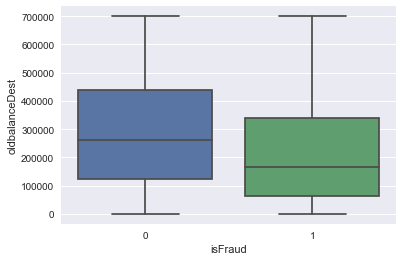

In [28]:
sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = d[(d.oldbalanceDest > 0) & (d.oldbalanceDest < 700000)]);

# Conclusion - we can see that the oldbalanceDest is lower on average on fraudulent transactions

In [29]:
#### Inspect the distribution of newbalanceOrig per fraud/nonfraud

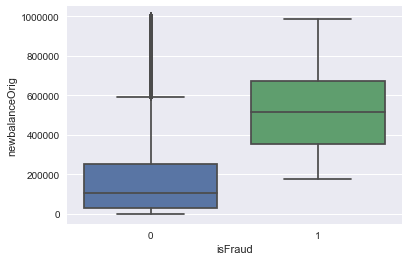

In [30]:
sns.boxplot(x = 'isFraud', y = 'newbalanceOrig', data = d[(d.newbalanceOrig > 0) & (d.newbalanceOrig < 1000000)]);

# Conclusion - we can see that the newbalanceOrig is significanly higher on average on fraudulent transactions

#### Inspect the distribution of newbalanceDest per fraud/nonfraud

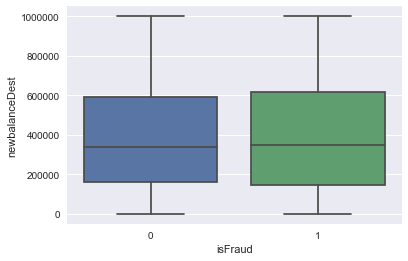

In [31]:
sns.boxplot(x = 'isFraud', y = 'newbalanceDest', data = d[(d.newbalanceDest > 0) & (d.newbalanceDest < 1000000)]);

# There is little differentitation - this variable is potentially not very informative

# Feature extraction

In [32]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer

# RecategorizeType - recategorises the type variable so that nonfraud categories are one category
# ExtractRecipientType - extract the type of recipient: M or C
# StepToHour - extracts hour of day
# StepToDay - extracts day of week

mapper = DataFrameMapper([
    ('type', [LabelBinarizer()]),
    ('nameDest', [ExtractRecipientType(), LabelBinarizer()], {'alias': 'recipient_type'}),
    ('step', StepToHour(), {'alias': 'hour'}),
    ('step', StepToDay(), {'alias': 'day'}),
    ('amount', None),
    ('oldbalanceOrg', None),
    ('newbalanceOrig', None),
    ('oldbalanceDest', None),
    ('newbalanceDest', None)
], df_out=True)

# MODEL TRAINING

Model training consists of several steps:


* We first split to training and testing samples. The test set serves as the validation set, and the true test set used at the end is not used in this exercise.


* We then undersample the majority class to the ratio of 10% fraud rate
    * We use simple vanilla undersample, where we randomly select a sample from the non fraud cases to achieve desired class ratio.
    * The undersample() function is defined in ```aux.py```.
    

* ML algorithm of choice is the random forest algorithm for several reasons:
    * It is tree based, and hence can automatically take care of interactions between features, hence we do not have to manually engineer such features.
    * Given that it is tree based, it can also automatically take care of ordered nominal features (e.g. hour, day), so that we do not have to introduce encoding for such variables. Categorical variables still need to be encoded since used implementation does not support using non-numeric variables.
    * Trees also take care of severely imbalanced numerical variables such as oldbalanceDest or newbalanceDest, where balance with customers of type M are automatically set to 0.
    * Performance-wise it is among the best algorithms.
    * It is relatively simple to tune (not in focus in this exercise).
    
    
* After fitting the ML algorithm, we conduct a simple profitability calculation (based on the assumption that the cost ratio of misclassified fraud to misclassified nonfraud is 10:1) to provide the optimal threshold (cutoff) point, so that the output is a binary response.

#### Split to training and testing datasets and undersample.

In [33]:
# train_ and test_ hold original samples.

from sklearn.model_selection import train_test_split

# We also want to keep original population samples, so undersample separately
train_, test_ = train_test_split(d, test_size=0.3, random_state=42)

In [34]:
train = undersample(train_, 0.1)
test = undersample(test_, 0.1)

#### Check whether the split to train and test sets is balanced in target variable

In [35]:
print("Number of target non-events in train: %d" % (train_.shape[0] - train_.isFraud.sum()))
print("Number of target non-events in test: %d\n" % (test_.shape[0] - test_.isFraud.sum()))


print("Number of target events in train:", train_.isFraud.sum())
print("Number of target events in test: ", test_.isFraud.sum())

print("Ratio of events in train (should be close to 70%%): %.3f%%" % (100 * train_.isFraud.sum() / (train_.isFraud.sum() + test_.isFraud.sum())))

Number of target non-events in train: 4448056
Number of target non-events in test: 1906351

Number of target events in train: 5778
Number of target events in test:  2435
Ratio of events in train (should be close to 70%): 70.352%


#### Fit mapper

In [36]:
mapper.fit(d);

In [37]:
trainMapped = mapper.transform(train)
testMapped = mapper.transform(test)

#### Adjust prior weights to take into account undersampling to 10% fraud case class.

In [38]:
# undersampled proportions of frauds and non frauds
sample1 = 0.1
sample0 = 0.9

# population proportions of frauds and non frauds
pop1 = sum(train_.isFraud) / train_.shape[0]
pop0 = 1 - sum(train_.isFraud) / train_.shape[0]

# class weights
wt = {0: pop0/sample0,
      1: pop1/sample1}

#### Fit random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=7,
                               min_samples_leaf=20, n_jobs=4)

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import fbeta_score, make_scorer

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def precRecAUC(ground_truth, predictions):
    from sklearn.metrics import auc
    precision, recall, thresh = precision_recall_curve(ground_truth, predictions)
    aucPrecRec = auc(recall, precision)
    return aucPrecRec

score = make_scorer(precRecAUC, greater_is_better=True)

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(2, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(20, 100),
              "n_estimators": sp_randint(20, 500)}

n_iter_search = 25
random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring=score,
                                   n_iter=n_iter_search, random_state=42)
random_search.fit(trainMapped, train.isFraud)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.959 (std: 0.005)
Parameters: {'max_depth': None, 'max_features': 9, 'min_samples_leaf': 43, 'min_samples_split': 4, 'n_estimators': 169}

Model with rank: 2
Mean validation score: 0.957 (std: 0.006)
Parameters: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 48, 'min_samples_split': 2, 'n_estimators': 364}

Model with rank: 3
Mean validation score: 0.954 (std: 0.005)
Parameters: {'max_depth': None, 'max_features': 9, 'min_samples_leaf': 56, 'min_samples_split': 4, 'n_estimators': 191}



In [41]:
model = random_search.best_estimator_

In [42]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(random_state=42, n_estimators=30, max_depth=10,
#                                min_samples_leaf=20, n_jobs=4)
# model.fit(trainMapped, train.isFraud)

#### Plot feature importance

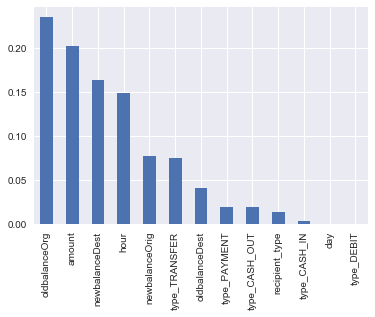

In [43]:
pd.Series(model.feature_importances_, index=trainMapped.columns).sort_values(ascending=False).plot(kind='bar');

#### Save the pipeline to disk, so that it can be used in the streaming application

In [44]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('mapper', mapper), 
                     ('model', model)])

#### Predictions for training and testing datasets

In [45]:
y_train = pipeline.predict_proba(train)
y_test = pipeline.predict_proba(test)

#### Calculate precision and recall

In [46]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresh = precision_recall_curve(train.isFraud, y_train[:,1])
precisionT, recallT, threshT = precision_recall_curve(test.isFraud, y_test[:,1])

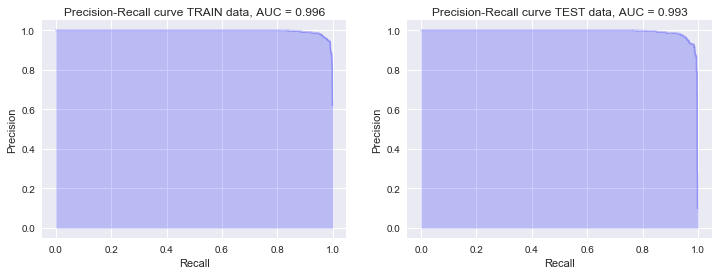

In [47]:
plt.figure(num=None, figsize=(12, 4))

plt.subplot(121)
plotPrecRecCurve(precision, recall, "TRAIN")

plt.subplot(122)
plotPrecRecCurve(precisionT, recallT, "TEST")

#### Calculate and plot ROC curve

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, threshROC = roc_curve(train.isFraud, y_train[:,1], drop_intermediate=False)
# fprT, tprT, threshROCT = roc_curve(test_.isFraud, pipeline.predict_proba(test_)[:,1], drop_intermediate=False)
fprT, tprT, threshROCT = roc_curve(test.isFraud, y_test[:,1], drop_intermediate=False)

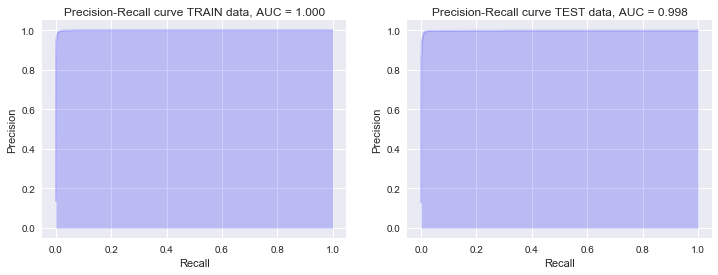

In [49]:
plt.figure(num=None, figsize=(12, 4))

plt.subplot(121)
plotPrecRecCurve(tpr, fpr, "TRAIN")

plt.subplot(122)
plotPrecRecCurve(tprT, fprT, "TEST")

#### Threshold definition

To set the threshold we run a profitability calculation to determine the optimal threshold level. We therefore assume that the cost of misclassifying a fraud vs non fraud is 10:1. We assume no benefit if correctly classifying frauds and non frauds.

In [50]:
fprT, tprT, threshROCT = roc_curve(d.isFraud, pipeline.predict_proba(d)[:,1], drop_intermediate=False)

In [51]:
pFraud = d.isFraud.sum()/d.shape[0]
pNonFraud = 1-pFraud

# profitability calculation
prof = pd.concat([pd.DataFrame({'pNonFraud': 1-threshROCT, 'pFraud': threshROCT}),
                  pd.DataFrame({'fpr': fprT, 'tpr': tprT})], axis=1) >> \
    arrange(X.pFraud) >> \
    mutate( TotalCost = float(pFraud) * ((1-X.tpr) * 10) + float(pNonFraud) * (X.fpr * 1) )

    
# select threshold where cost is minimal
threshold = prof >> \
    mask(X.TotalCost == np.min(X.TotalCost)) >> \
    select('pFraud') >>\
    rename(threshold=X.pFraud)
    
prof >> \
    mask(X.TotalCost == np.min(X.TotalCost))

,pFraud,pNonFraud,fpr,tpr,TotalCost
8034,0.764081,0.235919,0.000612,0.868501,0.002308


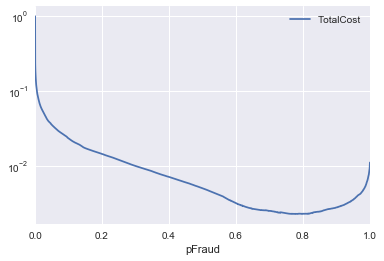

In [52]:
# Plot the cost function
prof.plot(x='pFraud', y='TotalCost', kind='line', logy=True);

#### Comparison of the sampled and original populations of predicted probabilities on the test sample
* Plots show that the fitted model provides very good differentiation between the fraud and non-fraud cases

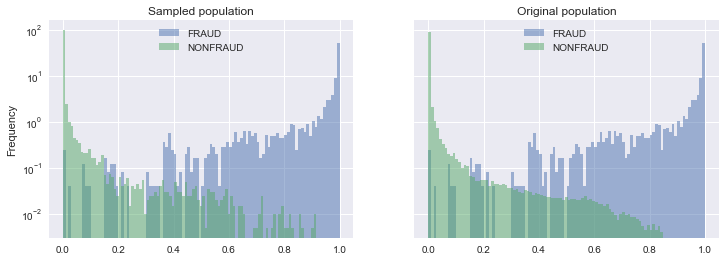

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

pd.Series(pipeline.predict_proba(test)[test.isFraud==1,1]).plot(kind='hist', bins=100, ax=axes[0], logy=True, normed=1, title='Sampled population', alpha=0.5);
pd.Series(pipeline.predict_proba(test)[test.isFraud==0,1]).plot(kind='hist', bins=100, ax=axes[0], logy=True, normed=1, title='Sampled population', alpha=0.5);

pd.Series(pipeline.predict_proba(test_)[test_.isFraud==1,1]).plot(kind='hist', bins=100, ax=axes[1], logy=True, normed=1, title='Original population', alpha=0.5);
pd.Series(pipeline.predict_proba(test_)[test_.isFraud==0,1]).plot(kind='hist', bins=100, ax=axes[1], logy=True, normed=1, title='Original population', alpha=0.5);

axes[0].legend({'FRAUD': 0, 'NONFRAUD': 1});
axes[1].legend({'FRAUD': 0, 'NONFRAUD': 1});

#### Save final prediction class with threshold

In [54]:
predClass = predictClass(pipeline=pipeline, threshold=threshold.iloc[0]['threshold'])


with open(os.path.join(ROOT, 'models', 'pipeline.pickle'), 'wb') as handle:
    pickle.dump(predClass, handle, protocol=pickle.HIGHEST_PROTOCOL)